# Выбор локации для скважины
# Choosing a location for a oil well

Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy import stats as st

In [2]:
#ЗАДАНИЕ КОНСТАНТ

#количество точек для исследования в регионе
NUMBER_RESEARCH_POINTS = 500

#количество лучших точек
NUMBER_BEST_POINTS = 200

#Бюджет на разработку скважин в регионе — 10 млрд рублей.
BUDGET_DEVELOPMENT = 10e9

#Доход с одиного барреля сырья 450 рублей
REVENUE_PER_BARREL = 450

#Доход с 1000 баррелей сырья 450 тыс. рублей
REVENUE_1000_BARREL = 450000

#вероятность убытков. 2,5%
PROBABILITY_LOSSES = 2.5 / 100

#число случайности для разных функций и моделей
STATE = 12345

In [3]:
#чтение трех датасетов
pth1 = 'geo_data_0.csv'
pth2 = '/datasets/geo_data_0.csv'

if os.path.exists(pth1):
    gd0 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    gd0 = pd.read_csv(pth2)
else:
    print('Something is wrong, что-то пошло не так как надо')
    
    
pth1 = 'geo_data_1.csv'
pth2 = '/datasets/geo_data_1.csv'

if os.path.exists(pth1):
    gd1 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    gd1 = pd.read_csv(pth2)
else:
    print('Something is wrong, что-то пошло не так как надо')

    
pth1 = 'geo_data_2.csv'
pth2 = '/datasets/geo_data_2.csv'

if os.path.exists(pth1):
    gd2 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    gd2 = pd.read_csv(pth2)
else:
    print('Something is wrong, что-то пошло не так как надо')


In [4]:
#функция для предварительного изучения таблиц
def what_data(df):
    display('**************************************DATA_OF_TABLE********************************')

    print(' ___________________')
    print('|--------INFO-------|')
    df.info(memory_usage='deep')
    print()
    
    print(' ___________________')
    print('|-------SAMPLE------|')
    display(df.sample(5))
    print()
    
    print('Dublicated_row =',df.duplicated().sum())
    print()
    
    print(' ___________________')
    print('|------DESCRIBE-----|')
    display(df.describe())
    print()

    print(' ___________________')
    print('|----CORRELATION----|')
    display(df.corr())
    print()

    print(' ___________________')
    print('|-----HISTOGRAM-----|')
    df.hist(bins=20, figsize=(6, 6))
    

'**************************************DATA_OF_TABLE********************************'

 ___________________
|--------INFO-------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB

 ___________________
|-------SAMPLE------|


,id,f0,f1,f2,product
15539,OmMpL,1.498588,-0.506240,2.010793,47.324259
24047,dxiT7,-0.043550,0.042982,1.131281,36.718028
21214,4mwPw,0.038442,0.975447,6.790045,98.548640
93938,14GfN,0.983007,-0.548489,0.831530,140.290198
60668,Zn4ru,-0.035350,0.107563,1.171804,150.342586



Dublicated_row = 0

 ___________________
|------DESCRIBE-----|


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



 ___________________
|----CORRELATION----|


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000



 ___________________
|-----HISTOGRAM-----|


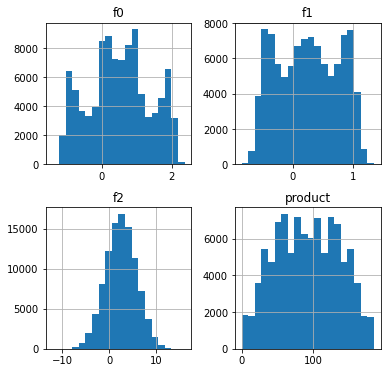

In [5]:
#информация для датасета geo_data_0
what_data(gd0)

'**************************************DATA_OF_TABLE********************************'

 ___________________
|--------INFO-------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB

 ___________________
|-------SAMPLE------|


,id,f0,f1,f2,product
11806,HSPUS,15.283873,-1.876274,3.994810,107.813044
94082,hyl9I,15.250561,-3.833152,-0.006011,0.000000
73561,K4Apt,15.181290,-3.017523,1.998645,53.906522
19643,4w47L,-14.536729,-10.654265,4.998928,137.945408
55590,aNzh3,17.043014,-7.403515,1.994728,53.906522



Dublicated_row = 0

 ___________________
|------DESCRIBE-----|


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



 ___________________
|----CORRELATION----|


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000



 ___________________
|-----HISTOGRAM-----|


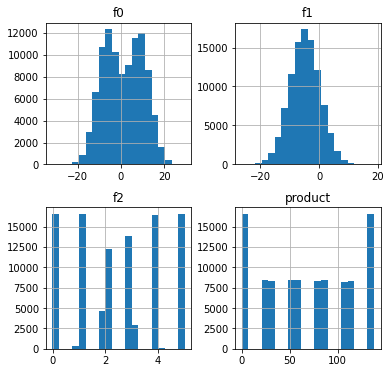

In [6]:
#информация для датасета geo_data_1
what_data(gd1)

'**************************************DATA_OF_TABLE********************************'

 ___________________
|--------INFO-------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB

 ___________________
|-------SAMPLE------|


,id,f0,f1,f2,product
61206,1lpBc,-0.276154,2.779701,-1.891195,95.014393
81413,tJOJ6,0.332789,-1.440828,10.984981,126.472773
96301,2lqWi,-1.807201,0.673248,-0.157492,77.771201
7714,D8blI,1.310006,-2.231924,7.156530,160.853528
97171,vMhkw,0.057291,-1.518030,1.794880,0.566521



Dublicated_row = 0

 ___________________
|------DESCRIBE-----|


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



 ___________________
|----CORRELATION----|


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000



 ___________________
|-----HISTOGRAM-----|


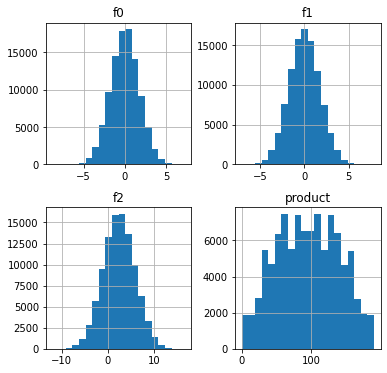

In [7]:
#информация для датасета geo_data_2
what_data(gd2)

Проверка наличия в датасете 0 скважин с одинаковым id

In [8]:
gd0.id.nunique()

99990

In [9]:
#подсчет количества уникальных значений id
gd0_vc = gd0.id.value_counts()

In [10]:
#отбор только тех id, которых встретилось больше 2-х
gd0_vc = list(gd0_vc[gd0_vc > 1].index)

In [11]:
#проверка
gd0_vc

['HZww2',
 'A5aEY',
 'AGS9W',
 'Tdehs',
 'TtcGQ',
 'QcMuo',
 'bxg6G',
 '74z30',
 'bsk9y',
 'fiKDv']

In [12]:
#вывод на экран строк с одинаковыми id скважин
gd0.query('id == @gd0_vc').sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


В датасете `geo_data_0` есть скважины с одинаковым id, но при этом скважины имеют разные параметры.

Таких строк 10 шт из 100 000, то есть их не много, около 0.01%.

Скорее всего для таких строк лучше выяснить "почему они есть" или просто удалить из датасета.

Такая же проверка для датасета 1

In [13]:
gd1.id.nunique()

99996

In [14]:
gd1_vc = gd1.id.value_counts()

In [15]:
gd1_vc = list(gd1_vc[gd1_vc > 1].index)

In [16]:
gd1.query('id == @gd1_vc').sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


Такая же проверка для датасета 2

In [17]:
gd2.id.nunique()

99996

In [18]:
gd2_vc = gd2.id.value_counts()

In [19]:
gd2_vc = list(gd2_vc[gd2_vc > 1].index)

In [20]:
gd2.query('id == @gd2_vc').sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


В двух других датасетах `geo_data_1` и `geo_data_2` ситуация аналогичная:
- есть скважины с одинаковым id, но при этом скважины имеют разные параметры.

Этих строк 6 шт из 100 000.

###### Принимаю решение:
 строки не трогать, то есть не удалять и не оставлять одну из них.

### Просмотр строк в датасетах geo_data_0 и geo_data_1 с одинаковыми значениями в столбцах id

(поиск одинаковых скважин между датасетами)

In [21]:
#проверка количества совпадающих id в двух датасетах
gd0.id.isin(gd1.id).sum()

10

In [22]:
gd0[gd0.id.isin(gd1.id)].sort_values(by='id')

,id,f0,f1,f2,product
14777,CXJ2r,1.799663,0.152615,2.308270,124.783815
71547,L1Fdm,-0.870625,0.216046,6.551127,99.473405
87474,Mp3uM,0.233182,0.999516,1.626957,109.425501
1419,Q64YW,0.453692,0.851595,1.483317,137.265232
44057,Y2udP,1.226808,-0.482702,7.197720,178.864963
44242,g3RRG,1.256835,-0.594468,2.258115,36.909351
86152,gnA83,0.874183,0.658348,4.315275,78.952516
75589,it2OW,-0.649660,0.966137,7.852383,152.939409
66852,mpZhE,1.050752,0.001206,3.015799,102.323401
93783,pGQRI,0.042350,-0.052613,2.241901,168.331029


In [23]:
gd1[gd1.id.isin(gd0.id)].sort_values(by='id')

,id,f0,f1,f2,product
23086,CXJ2r,4.595329,-1.967882,4.000767,107.813044
76544,L1Fdm,-3.346138,1.878476,0.004355,3.179103
99975,Mp3uM,6.109864,-6.680806,4.995256,134.766305
94352,Q64YW,3.005548,-0.243063,5.000265,134.766305
97856,Y2udP,12.544203,5.897907,1.007743,26.953261
99665,g3RRG,5.884971,-3.853958,5.000735,134.766305
47203,gnA83,13.842436,-12.362831,4.003258,107.813044
81779,it2OW,-7.472182,-14.802085,4.005783,110.992147
75179,mpZhE,11.206881,-2.291883,1.003807,26.953261
46293,pGQRI,-5.171681,-0.546409,3.002864,84.038886


###### Просмотр строк в датасетах geo_data_1 и geo_data_2 с одинаковыми значениями в столбцах id

In [24]:
#проверка количества совпадающих id в двух датасетах
gd1.id.isin(gd2.id).sum()

4

In [25]:
gd1[gd1.id.isin(gd2.id)].sort_values(by='id')

,id,f0,f1,f2,product
44738,D8TNs,-0.646266,3.667055,1.006161,30.132364
28877,TAqwC,-13.045712,-13.056006,0.007640,3.179103
92366,g2I86,17.818406,2.946716,0.991640,26.953261
38405,uMqiK,2.734183,-3.102346,-0.002654,0.000000


In [26]:
gd2[gd2.id.isin(gd1.id)].sort_values(by='id')

,id,f0,f1,f2,product
61622,D8TNs,0.280382,0.061393,4.887870,114.943876
80750,TAqwC,-0.176382,-0.503558,1.877303,38.618695
17007,g2I86,-1.616730,1.110380,4.226968,107.940639
40478,uMqiK,-1.772509,0.152085,-0.422541,119.682928


###### Просмотр строк в датасетах geo_data_0 и geo_data_2 с одинаковыми значениями в столбцах id

In [27]:
#проверка количества совпадающих id в двух датасетах
gd0.id.isin(gd2.id).sum()

17

In [28]:
gd0[gd0.id.isin(gd2.id)].sort_values(by='id')

,id,f0,f1,f2,product
45429,2tyMi,0.576679,-0.411140,-3.725859,69.292672
16753,5ssQt,-1.005117,0.268726,-0.407822,53.206029
58790,G6k8A,-0.332671,0.873613,0.056776,59.356289
88811,H2jd8,-0.095755,0.549838,4.798969,121.587791
69637,LhkAh,-0.016588,0.311455,5.752433,100.077127
65468,PyNp5,0.800617,-0.423276,-0.262853,37.280078
11615,Suyut,1.034755,0.211378,5.166985,134.183249
50393,TXPOv,-0.614415,0.669327,4.392560,111.029432
84954,eVdPR,0.948962,0.470545,4.841681,114.217840
10765,i2csb,1.876060,0.130102,3.916158,178.191619


In [29]:
gd2[gd2.id.isin(gd0.id)].sort_values(by='id')

,id,f0,f1,f2,product
27380,2tyMi,-1.789602,-1.359044,-4.840745,145.901447
72896,5ssQt,-0.651825,0.782415,2.690636,120.108761
91259,G6k8A,3.021943,2.091350,2.325737,81.922702
31306,H2jd8,-0.882244,0.102113,5.132965,97.736331
9042,LhkAh,-1.011388,-1.422994,0.167327,97.289509
97706,PyNp5,-1.248973,-1.246669,-0.538638,122.021857
57741,Suyut,0.730034,0.998910,0.673342,51.978338
17551,TXPOv,-1.714714,0.545975,6.907380,109.685043
82577,eVdPR,-3.325910,0.212653,-2.172340,61.323206
13672,i2csb,0.395736,-1.039466,3.262824,136.079194


### Выводы

Все датасеты не имеют пропущенных значений.

Количество строк одинаковое во всех датасетах, в каждом по 100 000.

Значения параметров скважин f0, f1, f1 типа float  и имеют отрицательные и положительные числа.

В некоторых датасетах значения столбцов имеют нормальное распределение, но в основном распределения не похожи на нормальные.

-- --
Имеется корреляция столба `f2` со столбцом `product`.

Практически 100%-я корреляция столба `f2` со столбцом `product` в датасете `geo_data_1`.

В остальных двух датасетах `geo_data_0` и `geo_data_2`, корреляция `f2` и `product` около 0,5.

Остальные параметры мало коррелированы друг с другом.

-- --
Внутри каждого датасета есть совпадающие по `id` скважины, 10, 4, 4 шт.

Между соседними датасетами так же есть совпадающие по `id` скважины. Их немного 4, 10 и 17 шт.

Несмотря на совпадающие `id` , параметры скважин (`f0`, `f1`, `f2`, `product`) абсолютно разные.

Скорее всего это или ошибка или одни и те же скважины одновременно попали в разные регионы добычи. Но при этом неясно почему у них разные параметры.

Так как соединять таблицы вместе не нужно, принимаю решение не удалять в датасетах строки с одинаковыми скважинами.

## Обучение и проверка модели

###### функция для обучения модели:

- разбивает данные на обучающую и валидационную выборки в соотношении 75:25.
- обучает модель Линейная регрессия и делает предсказания на валидационной выборке.
- сохраняет индекс строки из начального датасета, id скважины, правильные ответы и предсказания на валидационной выборке.

- печатает на экране:
 - средний запаса предсказанного сырья
 - RMSE модели.
 - `r2_score` модели.


In [30]:
def lin_regr(df):
    
    target = df['product']
    features = df.drop(['id', 'product'] , axis=1)
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, 
        target, 
        test_size=0.25, 
        random_state=STATE)

    model = LinearRegression()
    model.fit(features_train, target_train)
    
    predicted_valid = model.predict(features_valid) #предсказания модели на валидационых данных
    print("Средний запас предсказанного сырья =", round(predicted_valid.mean(), 2), ', тыс. баррелей')
    
    #отбираем индексы валидационной выборки
    valid_index = features_valid.index
    target_predicted_valid = (df.drop(['f0', 'f1', 'f2'] , axis=1) #убираем столбы с признаками (остаются индекс, id, верные ответы)
                              .iloc[valid_index] #отбираем только те строки которые имеют эти индексы
                              .reset_index() #сброс индексов
                              .join(pd.DataFrame(predicted_valid, columns=['product_pred']))#присоединяем предсказания
                             )
    
    mse = mean_squared_error(target_valid, predicted_valid)
    rmse = mse ** 0.5
    print("RMSE =", round(rmse, 2), ', тыс. баррелей')
    
    r2 = r2_score(target_valid, predicted_valid)
    print("R2 =", round(r2, 2))
    
    
    return target_predicted_valid, rmse

In [31]:
target_predicted_valid_0, rmse_0 = lin_regr(gd0)

Средний запас предсказанного сырья = 92.59 , тыс. баррелей
RMSE = 37.58 , тыс. баррелей
R2 = 0.28


In [32]:
#проверка правильности получившейся таблицы
target_predicted_valid_0

,index,id,product,product_pred
0,71751,7Z2gx,10.038645,95.894952
1,80493,b2HU8,114.551489,77.572583
2,2655,Y0dXD,132.603635,77.892640
3,53233,Mje59,169.072125,90.175134
4,91141,yqXxU,122.325180,70.510088
...,...,...,...,...
24995,12581,CzptN,170.116726,103.037104
24996,18456,cT9bJ,93.632175,85.403255
24997,73035,Y7xR6,127.352259,61.509833
24998,63834,4WJRf,99.782700,118.180397


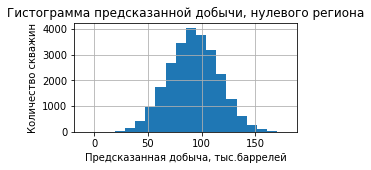

In [33]:
#гистограмма распределения предсказаний добычи
target_predicted_valid_0.product_pred.hist(bins=20, figsize=(4, 2))

#подписи к осям 
plt.xlabel('Предсказанная добыча, тыс.баррелей')
plt.ylabel('Количество скважин')

#заголовок к графику
plt.title('Гистограмма предсказанной добычи, нулевого региона')
plt.show()

In [34]:
target_predicted_valid_1, rmse_1 = lin_regr(gd1)

Средний запас предсказанного сырья = 68.73 , тыс. баррелей
RMSE = 0.89 , тыс. баррелей
R2 = 1.0


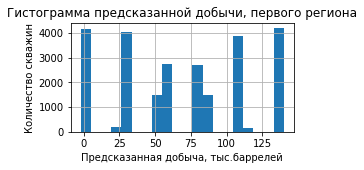

In [35]:
#гистограмма распределения предсказаний добычи
target_predicted_valid_1.product_pred.hist(bins=20, figsize=(4, 2))

#подписи к осям 
plt.xlabel('Предсказанная добыча, тыс.баррелей')
plt.ylabel('Количество скважин')

#заголовок к графику
plt.title('Гистограмма предсказанной добычи, первого региона')
plt.show()


In [36]:
target_predicted_valid_2, rmse_2 = lin_regr(gd2)

Средний запас предсказанного сырья = 94.97 , тыс. баррелей
RMSE = 40.03 , тыс. баррелей
R2 = 0.21


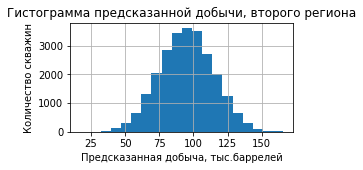

In [37]:
#гистограмма распределения предсказаний добычи
target_predicted_valid_2.product_pred.hist(bins=20, figsize=(4, 2))

#подписи к осям 
plt.xlabel('Предсказанная добыча, тыс.баррелей')
plt.ylabel('Количество скважин')

#заголовок к графику
plt.title('Гистограмма предсказанной добычи, второго региона')
plt.show()


### Выводы

Наилучшие результаты показала модель для датасета `geo_data_1`. Её `RMSE` равен 0,89, а `R2_score = 1`.

Возможно это связано с сильной корреляцией у этого датасета столбца `f2` с `product`.

Модели для датасетов 0 и 2 имеют низкие результаты, большой разброс и низкое значение метрики `R2_score`

Таблица с результатами для трёх датасетов:

Название датасета |Ср.запас предсказанного сырья | RMSE | R2  |
------------------|----------------------------- |------|-----|
geo_data_0        | 92.59                        |37.58 |0.28 |
geo_data_1        | 68.73                        |0.89  |1.0  |
geo_data_2        | 94.97                        |40.03 |0.21 |

## Подготовка к расчёту прибыли

In [38]:
#вероятность убытков. 2,5%
#probability_losses = 2.5 / 100

Расчет необходимого объёма сырья для безубыточной разработки новой скважины. 

поскольку добывать нефть планируется с 200-т скважин,
то и расчёт средней по минимальной добыче с каждой скважины буду вести исходя из этого количества.

In [39]:
amount_barrel = BUDGET_DEVELOPMENT / (NUMBER_BEST_POINTS * REVENUE_1000_BARREL)

In [40]:
#средний обьем сырья, который должен быть добыт из скважины, для её безубыточности.
#в тысячах баррелей
amount_barrel

111.11111111111111

###### Выводы:

Средний запас предсказанного сырья, в любом из трех регионов, меньше чем требуется для безубыточной разработки новой скважины.
    
Судя по гистограммам, в ответах всех трёх моделей есть достаточное количество скважин с добычей больше чем 111тыс. баррелей.

## Расчёт прибыли и рисков 

    4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
	4.1. Выберите скважины с максимальными значениями предсказаний. 
	4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
	4.3. Рассчитайте прибыль для полученного объёма сырья.

In [41]:
#функция расчета прибыли
def profit_calculation(target_predicted_valid):
    filtred = (target_predicted_valid
               .sort_values(by='product_pred', ascending=False)#сортировка по убыванию
               [:NUMBER_BEST_POINTS]# отбор первых значений (в данном случае 200 штук)
              )
    
    sum_product_pred = filtred['product'].sum()#сумма по столбцу предсказаний добычи
    
     #возврат прибыли по отобранным скважинам (200 скважин)
    return sum_product_pred * REVENUE_1000_BARREL - BUDGET_DEVELOPMENT

In [42]:
#прибыль для региона 0
profit_0 = profit_calculation(target_predicted_valid_0)

In [43]:
profit_0

3320826043.1398506

In [44]:
#прибыль для региона 1
profit_1 = profit_calculation(target_predicted_valid_1)

In [45]:
profit_1

2415086696.681511

In [46]:
#прибыль для региона 2
profit_2 = profit_calculation(target_predicted_valid_2)

In [47]:
profit_2

2710349963.5998325

    5. Посчитайте риски и прибыль для каждого региона:
	5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
	5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
	5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [48]:
def bootstrap_ttest(target_predicted_valid, profit, alpha):

    state = np.random.RandomState(STATE)

    values = []

    for i in range(1000):
        subsample = target_predicted_valid.sample(n=NUMBER_RESEARCH_POINTS, replace=True, random_state=state)

        #высчитываем прибыль по 200 самых прибыльным скважинам и добавляем в список
        values.append(profit_calculation(subsample)) 
    
    values = pd.Series(values)

    lower = values.quantile(0.025)# считаем 2,5% квантиль получившейся выборки
    upper = values.quantile(0.975)# считаем 97,5% квантиль получившейся выборки

    print('Средняя прибыль', round(values.mean()/1e9, 3), 'млрд. рублей')
    print('95% доверительный интервал',[round(lower/1e9, 3), round(upper/1e9, 3)], ', в млрд. рублей')
    #print('len values =', len(values))
    (values/1e9).hist(bins=20, figsize=(4, 2.5))
    #подписи к осям 
    plt.xlabel('Прибыль, млрд.рубл')
    #plt.ylabel('количество точек')

    #заголовок к графику
    plt.title('Гистограмма распределения прибыли')
    plt.show()
    
    #риск убытков
                  
    print('Риск убытков', 100 * values[values < 0].count()/len(values), '%')
    #print(values[values < 0])

Средняя прибыль 0.396 млрд. рублей
95% доверительный интервал [-0.111, 0.91] , в млрд. рублей


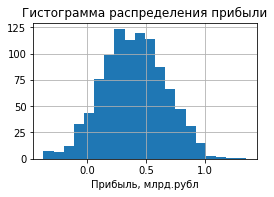

Риск убытков 6.9 %


In [49]:
bootstrap_ttest(target_predicted_valid_0, profit_0, alpha=PROBABILITY_LOSSES)

Средняя прибыль 0.456 млрд. рублей
95% доверительный интервал [0.034, 0.852] , в млрд. рублей


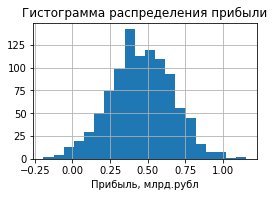

Риск убытков 1.5 %


In [50]:
bootstrap_ttest(target_predicted_valid_1, profit_1, alpha=PROBABILITY_LOSSES)

Средняя прибыль 0.404 млрд. рублей
95% доверительный интервал [-0.163, 0.95] , в млрд. рублей


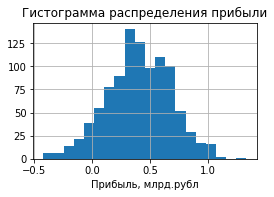

Риск убытков 7.6 %


In [51]:
bootstrap_ttest(target_predicted_valid_2, profit_2, alpha=PROBABILITY_LOSSES)

## Выводы

Все три региона 0, 1 и 2 подходят для безубыточной разработки.

Средняя прибыль в регионах составляет 0.396, 0.456 и 0.404 млрд. рублей соответственно.

Риски убытков по регионам 6.9%, 1.5%, 7.6% соответственно. И только один регион, имеет риск меньше чем вероятность убытков 2,5%.

Минимальный риск имеет "первый" регион, "нулевой" и "второй" регионы имеют риски более чемм 2,5%

Соответственно для разработки скважин предлагаю использовать регион 1.